In [50]:
import pandas as pd
import numpy as np
import zipfile
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import joblib

In [51]:
plt.style.use('ggplot')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

========== 1. CARREGAR DADOS ==========

In [52]:
zip_path = "D:/Security-IA/csv/MachineLearningCVE.zip"
extract_to = "D:/Security-IA/data/raw"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

data_dir = extract_to
csv_files = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)

print(f"Arquivos encontrados: {len(csv_files)}")

dataframes = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    print(f"{os.path.basename(file)} -> {df_temp.shape[0]:,} linhas, {df_temp.shape[1]} colunas")
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)
print(f"\nDataset final: {df.shape[0]:,} linhas e {df.shape[1]} colunas")

Arquivos encontrados: 8
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv -> 225,745 linhas, 79 colunas
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv -> 286,467 linhas, 79 colunas
Friday-WorkingHours-Morning.pcap_ISCX.csv -> 191,033 linhas, 79 colunas
Monday-WorkingHours.pcap_ISCX.csv -> 529,918 linhas, 79 colunas
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv -> 288,602 linhas, 79 colunas
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv -> 170,366 linhas, 79 colunas
Tuesday-WorkingHours.pcap_ISCX.csv -> 445,909 linhas, 79 colunas
Wednesday-workingHours.pcap_ISCX.csv -> 692,703 linhas, 79 colunas

Dataset final: 2,830,743 linhas e 79 colunas


========== 2. LIMPEZA E PRE-PROCESSAMENTO ==========

In [53]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
linhas_antes = df.shape[0]
df.dropna(inplace=True)
linhas_depois = df.shape[0]
print(f"Linhas removidas por valores nulos/infinitos: {linhas_antes - linhas_depois:,}")

df.columns = df.columns.str.strip()

colunas_remover = [
    "Destination Port", "Fwd Header Length.1", "Init_Win_bytes_forward",
    "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward",
    "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets",
    "Subflow Bwd Bytes", "Average Packet Size"
]
df = df.drop(columns=colunas_remover, errors="ignore")
print(f"Total de colunas agora: {len(df.columns)}")

Linhas removidas por valores nulos/infinitos: 2,867
Total de colunas agora: 68


========== 3. AGRUPAR CLASSES RARAS ==========

In [54]:
print("\nAgrupando classes raras...")

def agrupar_classes(label):
    if 'Web Attack' in label:
        return 'Web Attack'
    elif 'DoS' in label and 'Hulk' not in label and 'GoldenEye' not in label:
        return 'DoS Other'
    elif 'Patator' in label:
        return 'Patator'
    elif label in ['Heartbleed', 'Infiltration']:
        return 'Other Rare Attack'
    else:
        return label

df['Label_Grouped'] = df['Label'].apply(agrupar_classes)

print("Distribuição após agrupamento:")
print(df['Label_Grouped'].value_counts())

# Usar a coluna agrupada
X = df.drop(['Label', 'Label_Grouped'], axis=1)
y = df['Label_Grouped']


Agrupando classes raras...
Distribuição após agrupamento:
Label_Grouped
BENIGN               2271320
DoS Hulk              230124
PortScan              158804
DoS Other             139320
Patator                13832
DoS GoldenEye          10293
Web Attack              2180
Bot                     1956
Other Rare Attack         47
Name: count, dtype: int64


========== 4. ANALISE DAS CLASSES ==========


Distribuição das classes (Label_Grouped):
Label_Grouped
BENIGN               2271320
DoS Hulk              230124
PortScan              158804
DoS Other             139320
Patator                13832
DoS GoldenEye          10293
Web Attack              2180
Bot                     1956
Other Rare Attack         47
Name: count, dtype: int64


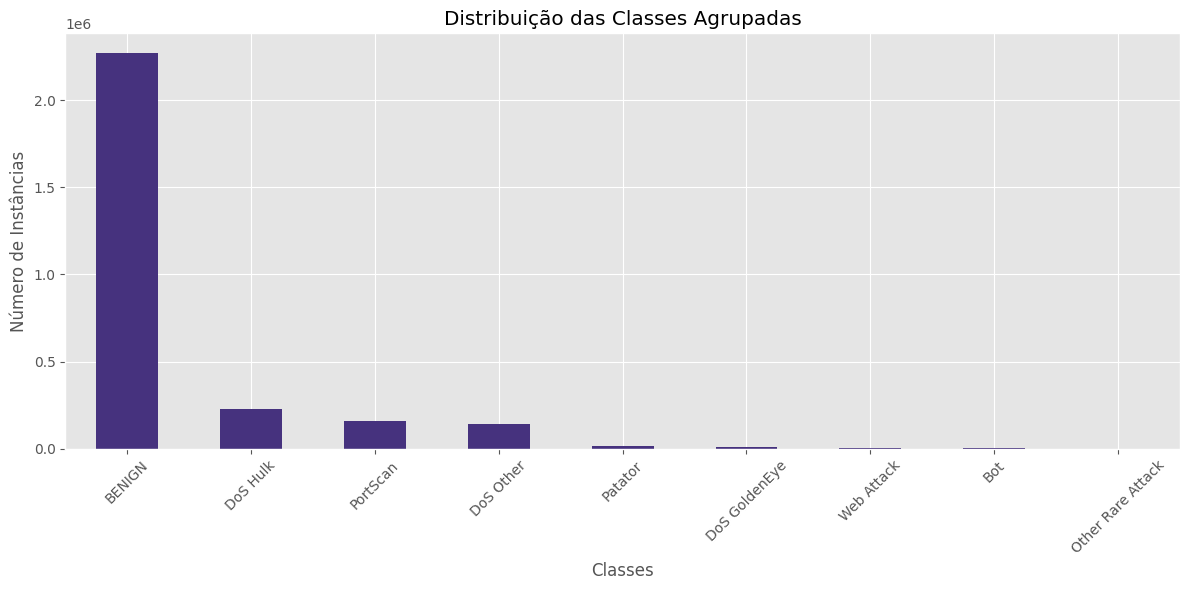

In [55]:
print("\nDistribuição das classes (Label_Grouped):")
distribuicao = y.value_counts()
print(distribuicao)

plt.figure(figsize=(12, 6))
distribuicao.plot(kind='bar')
plt.title("Distribuição das Classes Agrupadas")
plt.ylabel("Número de Instâncias")
plt.xlabel("Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

========== 5. SPLIT DOS DADOS ==========

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTreino: {X_train.shape[0]:,} amostras")
print(f"Teste: {X_test.shape[0]:,} amostras")


Treino: 2,262,300 amostras
Teste: 565,576 amostras


========== 6. CODIFICAR LABELS ==========

In [57]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Labels codificados corretamente")

# Mostrar mapeamento
print("\nMapeamento de classes:")
for i, classe in enumerate(le.classes_):
    print(f"{i} -> {classe}")

Labels codificados corretamente

Mapeamento de classes:
0 -> BENIGN
1 -> Bot
2 -> DoS GoldenEye
3 -> DoS Hulk
4 -> DoS Other
5 -> Other Rare Attack
6 -> Patator
7 -> PortScan
8 -> Web Attack


========== 7. SCALING SEM DATA LEAKAGE ==========

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados normalizados SEM data leakage")

Dados normalizados SEM data leakage


========== 8. BALANCEAMENTO COM UNDERSAMPLING ==========

In [61]:
# ========== 8. BALANCEAMENTO APENAS COM UNDERSAMPLING ==========
print("\nAplicando apenas undersampling na classe majoritária...")

from imblearn.under_sampling import RandomUnderSampler

# Verificar distribuição
unique, counts = np.unique(y_train_encoded, return_counts=True)
print("\nDistribuição ANTES do balanceamento:")
for cls, count in zip(unique, counts):
    print(f"Classe {cls} ({le.inverse_transform([cls])[0]}): {count:,} amostras")

# Manter todas as classes minoritárias como estão, só reduzir a majoritária
majority_class = np.argmax(counts)
majority_count = counts[majority_class]
target_samples = 20000  # Número razoável para a classe majoritária

sampling_strategy = {}
for cls, count in zip(unique, counts):
    if cls == majority_class:
        sampling_strategy[cls] = target_samples  # Reduzir a majoritária
    else:
        sampling_strategy[cls] = count  # Manter as outras

print(f"\nEstratégia: {sampling_strategy}")

# Aplicar undersampling
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_scaled, y_train_encoded)

print(f"\nApós balanceamento - Treino: {X_train_balanced.shape[0]:,} amostras")

# Verificar distribuição
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
print("\nDistribuição APÓS balanceamento:")
for cls, count in zip(unique_balanced, counts_balanced):
    print(f"Classe {cls} ({le.inverse_transform([cls])[0]}): {count:,} amostras")


Aplicando apenas undersampling na classe majoritária...

Distribuição ANTES do balanceamento:
Classe 0 (BENIGN): 1,817,055 amostras
Classe 1 (Bot): 1,565 amostras
Classe 2 (DoS GoldenEye): 8,234 amostras
Classe 3 (DoS Hulk): 184,099 amostras
Classe 4 (DoS Other): 111,456 amostras
Classe 5 (Other Rare Attack): 38 amostras
Classe 6 (Patator): 11,066 amostras
Classe 7 (PortScan): 127,043 amostras
Classe 8 (Web Attack): 1,744 amostras

Estratégia: {np.int64(0): 20000, np.int64(1): np.int64(1565), np.int64(2): np.int64(8234), np.int64(3): np.int64(184099), np.int64(4): np.int64(111456), np.int64(5): np.int64(38), np.int64(6): np.int64(11066), np.int64(7): np.int64(127043), np.int64(8): np.int64(1744)}

Após balanceamento - Treino: 465,245 amostras

Distribuição APÓS balanceamento:
Classe 0 (BENIGN): 20,000 amostras
Classe 1 (Bot): 1,565 amostras
Classe 2 (DoS GoldenEye): 8,234 amostras
Classe 3 (DoS Hulk): 184,099 amostras
Classe 4 (DoS Other): 111,456 amostras
Classe 5 (Other Rare Attack)

========== 9. SALVAR DADOS PROCESSADOS ==========

In [62]:
os.makedirs("D:/Security-IA/data/processed", exist_ok=True)

np.save("D:/Security-IA/data/processed/X_train_balanced.npy", X_train_balanced)
np.save("D:/Security-IA/data/processed/X_test_scaled.npy", X_test_scaled)
np.save("D:/Security-IA/data/processed/y_train_balanced.npy", y_train_balanced)
np.save("D:/Security-IA/data/processed/y_test.npy", y_test_encoded)

# Salvar também o LabelEncoder e Scaler
joblib.dump(le, "D:/Security-IA/data/processed/label_encoder.pkl")
joblib.dump(scaler, "D:/Security-IA/data/processed/scaler.pkl")

print("\n✓ Dados salvos com pré-processamento correto!")


✓ Dados salvos com pré-processamento correto!


In [63]:
print(f"\n=== RESUMO FINAL ===")
print(f"Classes após agrupamento: {len(le.classes_)}")
print(f"Amostras de treino balanceadas: {X_train_balanced.shape[0]:,}")
print(f"Amostras de teste: {X_test_scaled.shape[0]:,}")
print(f"Dimensões das features: {X_train_balanced.shape[1]}")


=== RESUMO FINAL ===
Classes após agrupamento: 9
Amostras de treino balanceadas: 465,245
Amostras de teste: 565,576
Dimensões das features: 67
